In [1]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu

from rpy2 import robjects
from rpy2.robjects import Formula

from rpy2.robjects import pandas2ri
pandas2ri.activate()

from rpy2.robjects.packages import importr

base = importr("base")
stats = importr("stats")
DESeq2 = importr("DESeq2")

/home/alexmakh/anaconda3/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# 1 

In [2]:
m = 10
a1, a2 = 6, 7
p1, p2 = 0.049, 0.051

print("m =", m)
print("k =", a1, " | pvalue =", p1, "| padj =", round(p1 * m / a1, 3))
print("k =", a2, " | pvalue =", p2, "| padj =", round(p2 * m / a2, 3))

m = 10
k = 6  | pvalue = 0.049 | padj = 0.082
k = 7  | pvalue = 0.051 | padj = 0.073


# 2

In [3]:
path = "https://raw.githubusercontent.com/s-a-nersisyan/HSE_bioinformatics_2021/master/seminar13/colon_cancer_tumor_vs_normal_paired_counts.tsv"
counts = pd.read_csv(path, sep="\t", index_col=0)
meta = pd.DataFrame({"Tissue": ["Tumor"]*5 + ["Normal"]*5, "Pairs": ["1","2","3","4","5"]*2}, index=counts.columns)
counts.head()

TCGA-A6-2671-01A  TCGA-A6-2675-01A  TCGA-A6-2678-01A  \
A1CF                  19              1087              1065   
A2M                 6205             22375              7410   
A4GALT               222               661                99   
AAAS                1373              1660              1307   
AACS                1490              1801              1350   

        TCGA-A6-2679-01A  TCGA-A6-2680-01A  TCGA-A6-2671-11A  \
A1CF                  28               511              2980   
A2M                  460              6517             31626   
A4GALT                81               225               757   
AAAS                 365              1250              1647   
AACS                 531              1960              2789   

        TCGA-A6-2675-11A  TCGA-A6-2678-11A  TCGA-A6-2679-11A  TCGA-A6-2680-11A  
A1CF                1005              4837              2246              6318  
A2M                34948             60304             36127             22337  
A4GALT              1114               746               513               668  
AAAS                1078              2007              1677              1440  
AACS                2662              2776              2755              2229

In [4]:
def calculate(meta, formul, counts):
    meta["Tissue"] = stats.relevel(robjects.vectors.FactorVector(meta["Tissue"]), ref="Normal")
    # Calculate normalization factors
    dds = DESeq2.DESeqDataSetFromMatrix(countData=counts, colData=meta, design=Formula(formul))
    dds = DESeq2.DESeq(dds)
    res = DESeq2.results(dds, name="Tissue_Tumor_vs_Normal")
    res = DESeq2.lfcShrink(dds, coef="Tissue_Tumor_vs_Normal", type="apeglm")
    res = pd.DataFrame(base.as_data_frame(res))
    res.index = counts.index
    res = res.sort_values("padj")
    res = res.loc[res["padj"] < 0.05]
    res = res.loc[res["log2FoldChange"].abs() >= 1]
    return res

In [5]:
paired = calculate(meta, "~ Tissue + Pairs", counts)
unpaired = calculate(meta, "~ Tissue", counts)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, ple

In [6]:
unpaired.head(10)

baseMean  log2FoldChange     lfcSE        pvalue  \
RP11-474D1.3   428.358064        9.178134  0.593908  1.364930e-54   
CDH3          1514.508985        7.240486  0.530773  9.231125e-44   
MMP11         3691.591790        5.176800  0.405912  1.842664e-38   
WNT2           200.409369        5.736149  0.463340  1.835779e-36   
ATG9B          165.549271        4.310814  0.349275  2.897243e-36   
CEMIP         2198.304767        5.345004  0.448791  6.104611e-34   
SPTBN2         784.826206        3.162476  0.266881  1.503094e-33   
GYLTL1B       1236.554809        5.805921  0.493538  3.394461e-33   
C2CD4A         543.941121        5.453214  0.472709  5.122209e-32   
TRIB3         2446.836922        4.814901  0.427638  1.258391e-30   

                      padj  
RP11-474D1.3  2.262371e-50  
CDH3          7.650295e-40  
MMP11         1.018072e-34  
WNT2          7.607009e-33  
ATG9B         9.604360e-33  
CEMIP         1.686399e-30  
SPTBN2        3.559111e-30  
GYLTL1B       7.032899e-30  
C2CD4A        9.433401e-29  
TRIB3         2.085784e-27

In [7]:
paired.head(10)

baseMean  log2FoldChange     lfcSE        pvalue  \
CDH3          1514.508985        7.188710  0.400967  5.266847e-76   
GYLTL1B       1236.554809        5.674997  0.366847  1.201853e-56   
C2CD4A         543.941121        5.388573  0.364641  3.293407e-51   
RP11-474D1.3   428.358064        9.312236  0.644642  7.640727e-50   
MMP7          1078.701661        8.553331  0.599580  2.128313e-49   
CST1           982.810903        9.974090  0.797161  1.267325e-44   
TRIM29        2029.220200        5.072389  0.383116  6.546098e-43   
GRIN2D         908.347260        5.253926  0.408049  2.604098e-41   
KLK10          737.470876        4.311383  0.328691  1.012235e-40   
KRT80          682.282434        6.276820  0.522522  2.727756e-39   

                      padj  
CDH3          8.842509e-72  
GYLTL1B       1.008896e-52  
C2CD4A        1.843100e-47  
RP11-474D1.3  3.207004e-46  
MMP7          7.146450e-46  
CST1          3.546188e-41  
TRIM29        1.570035e-39  
GRIN2D        5.465024e-38  
KLK10         1.888268e-37  
KRT80         4.579629e-36

In [8]:
pair_set = set(paired.index[:10])
unpair_set = set(unpaired.index[:10])
print("Paired:", paired.shape[0], "genes are differential expressed. Top-10:", ", ".join(paired.index[:10]), '\n')
print("Unpaired:", unpaired.shape[0], "genes are differential expressed. Top-10:", ", ".join(unpaired.index[:10]), '\n')
print("Common:", ", ".join(pair_set & unpair_set))

Paired: 3847 genes are differential expressed. Top-10: CDH3, GYLTL1B, C2CD4A, RP11-474D1.3, MMP7, CST1, TRIM29, GRIN2D, KLK10, KRT80 

Unpaired: 3698 genes are differential expressed. Top-10: RP11-474D1.3, CDH3, MMP11, WNT2, ATG9B, CEMIP, SPTBN2, GYLTL1B, C2CD4A, TRIB3 

Common: CDH3, C2CD4A, GYLTL1B, RP11-474D1.3


#  3

In [9]:
path = 'https://raw.githubusercontent.com/s-a-nersisyan/HSE_bioinformatics_2021/master/seminar13/colon_cancer_tumor_vs_normal_unpaired_FPKM.tsv'
fpkm = pd.read_csv(path, index_col=0, sep='\t')
ttest = [ttest_ind(fpkm.loc[gene].iloc[0:5], fpkm.loc[gene].iloc[5:10])[1] for gene in fpkm.index]

mw = [mannwhitneyu(fpkm.loc[gene].iloc[0:5], fpkm.loc[gene].iloc[5:10])[1] for gene in fpkm.index]
df = pd.DataFrame({'ttest': ttest, 'mw': mw}, index=fpkm.index)

t_set = set(df.nsmallest(10, 'ttest').index)
m_set = set(df.nsmallest(10, 'mw').index)

df.head()

ttest        mw
A1CF    0.005837  0.010786
A2M     0.021117  0.047346
A4GALT  0.530473  0.417266
AAAS    0.051734  0.071836
AACS    0.428299  0.417266

In [10]:
path = "https://raw.githubusercontent.com/s-a-nersisyan/HSE_bioinformatics_2021/master/seminar13/colon_cancer_tumor_vs_normal_unpaired_counts.tsv"
counts = pd.read_csv(path, sep="\t", index_col=0)
meta = pd.DataFrame({"Tissue": ["Tumor"]*5 + ["Normal"]*5, "Pairs": ["1","2","3","4","5"]*2}, index=counts.columns)
df1 = calculate(meta, '~ Tissue', counts)
d_set = set(df1.nsmallest(10, 'padj').index)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [11]:
print('deseq and mw:', m_set & d_set)
print('deseq and ttest:', t_set & d_set)
print('ttest and mw:', t_set & m_set)

deseq and mw: set()
deseq and ttest: {'C17orf96', 'IER5L', 'FUT1'}
ttest and mw: set()


# 4 

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

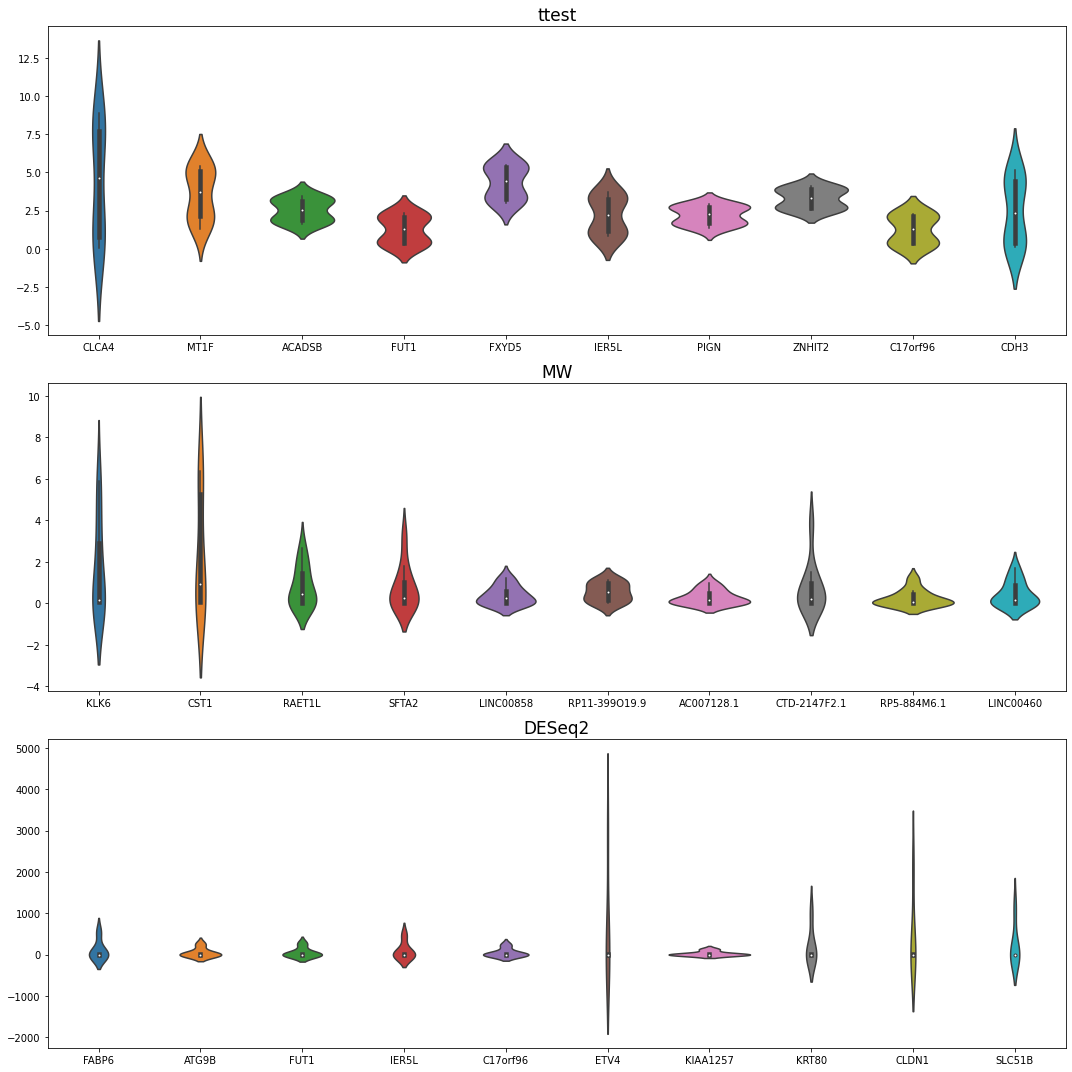

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
size = 17
sns.violinplot(data=fpkm.loc[t_set].T, ax=ax[0]).set_title('ttest', size=size)
sns.violinplot(data=fpkm.loc[m_set].T, ax=ax[1]).set_title('MW', size=size)
sns.violinplot(data=df1.loc[d_set].T, ax=ax[2]).set_title('DESeq2', size=size)

plt.tight_layout()
plt.show()

# 5

In [14]:
import pandas as pd

all_genes = pd.read_csv("https://raw.githubusercontent.com/s-a-nersisyan/HSE_bioinformatics_2021/master/seminar13/all_genes.txt", header=None)[0]

df = pd.DataFrame(index=all_genes)
for i in range(1, 6):
    df.sample(1000).to_csv(f"./Sample{i}.txt", header = False)

https://david.ncifcrf.gov/data/download/chart_FC637EAD3F1C1619481000540.txt

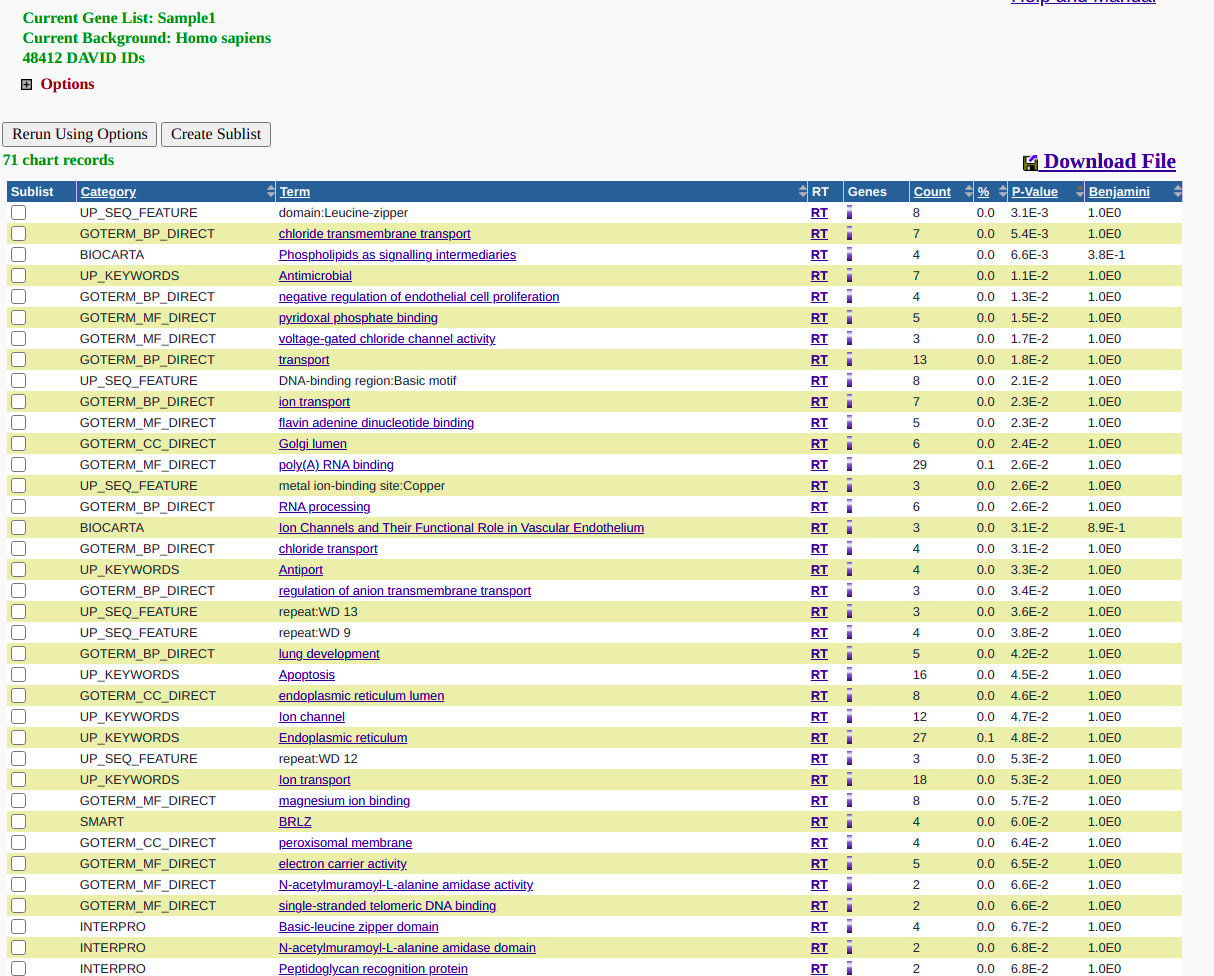

https://david.ncifcrf.gov/data/download/chart_FC637EAD3F1C1619481502307.txt

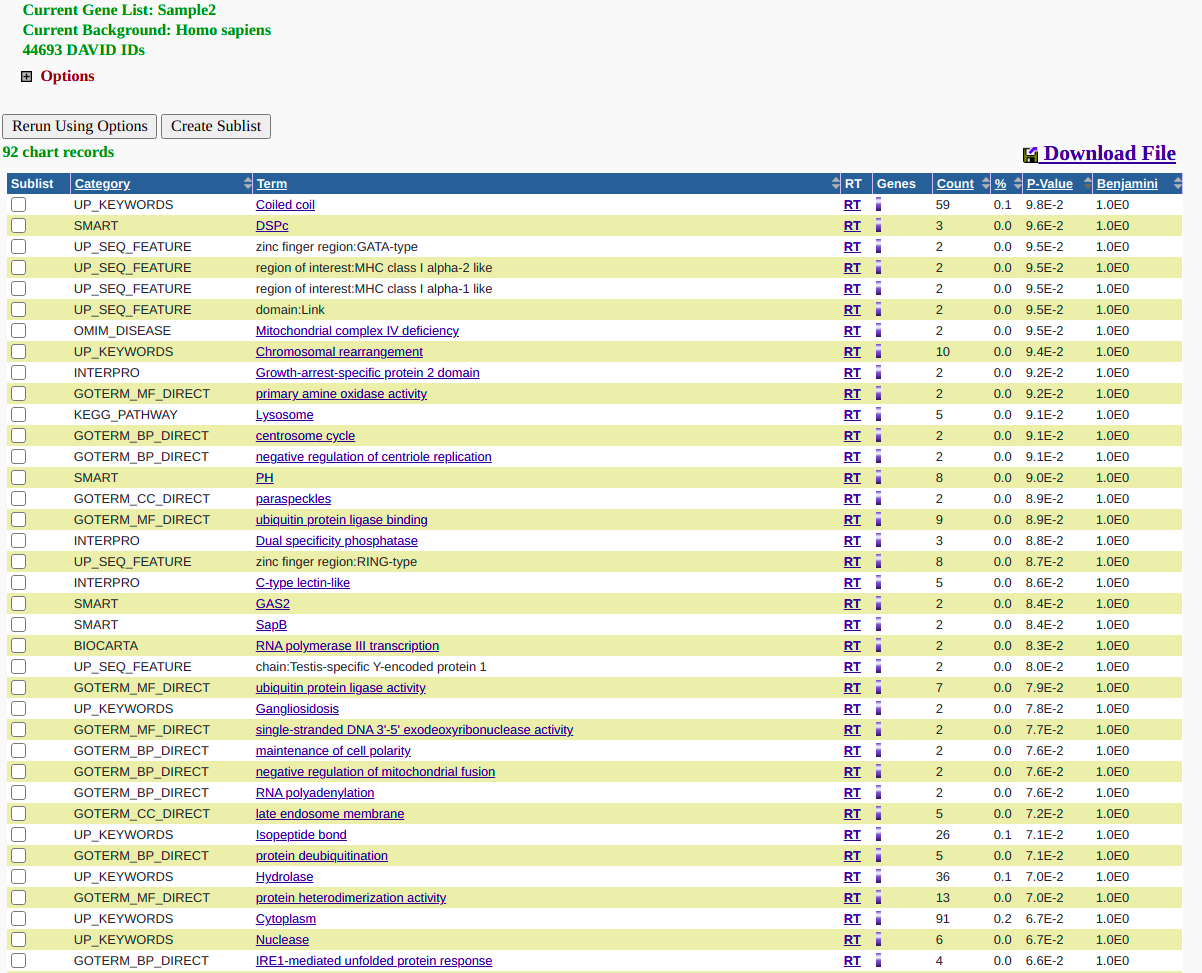

https://david.ncifcrf.gov/data/download/chart_FC637EAD3F1C1619482176791.txt

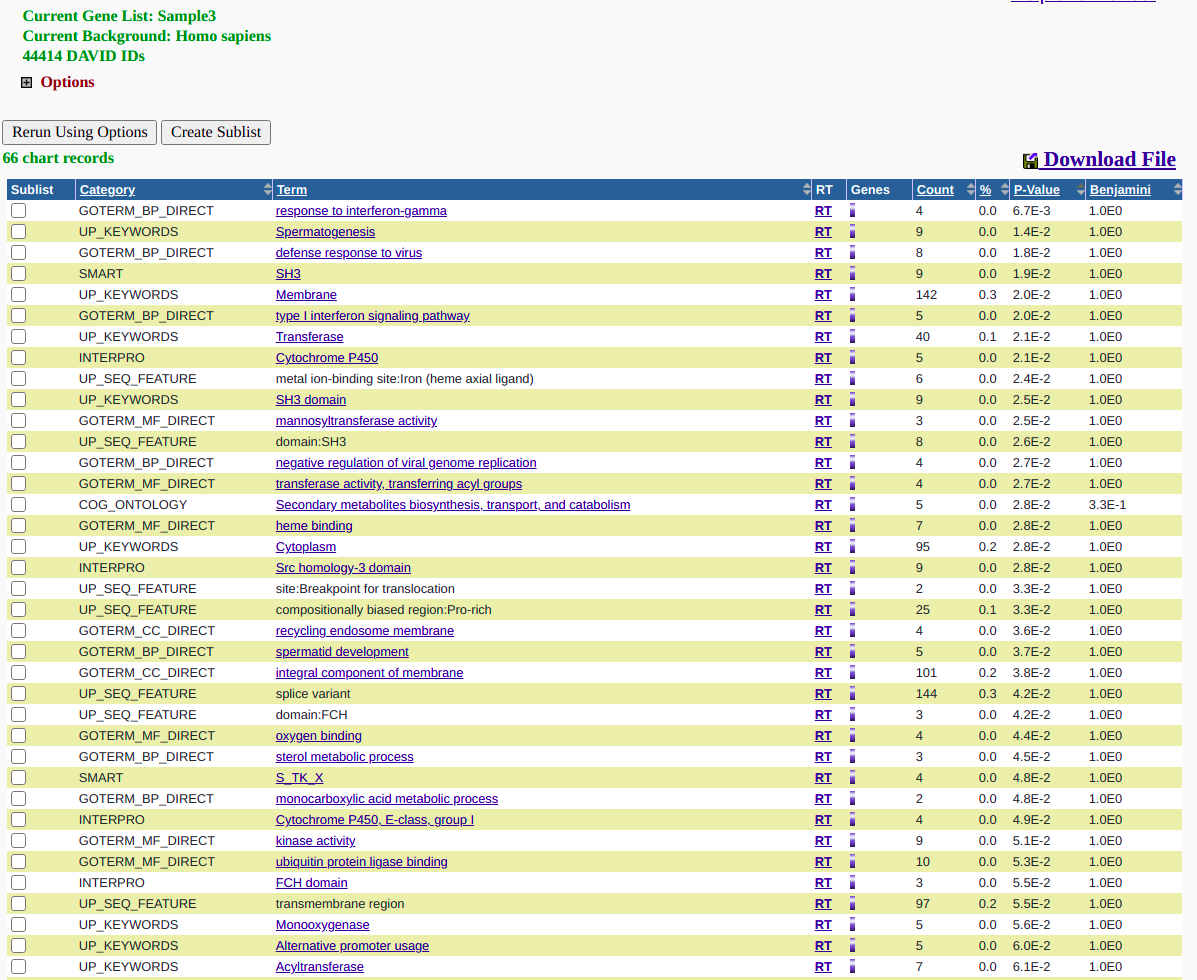

https://david.ncifcrf.gov/data/download/chart_40A4796FAD681619481596092.txt

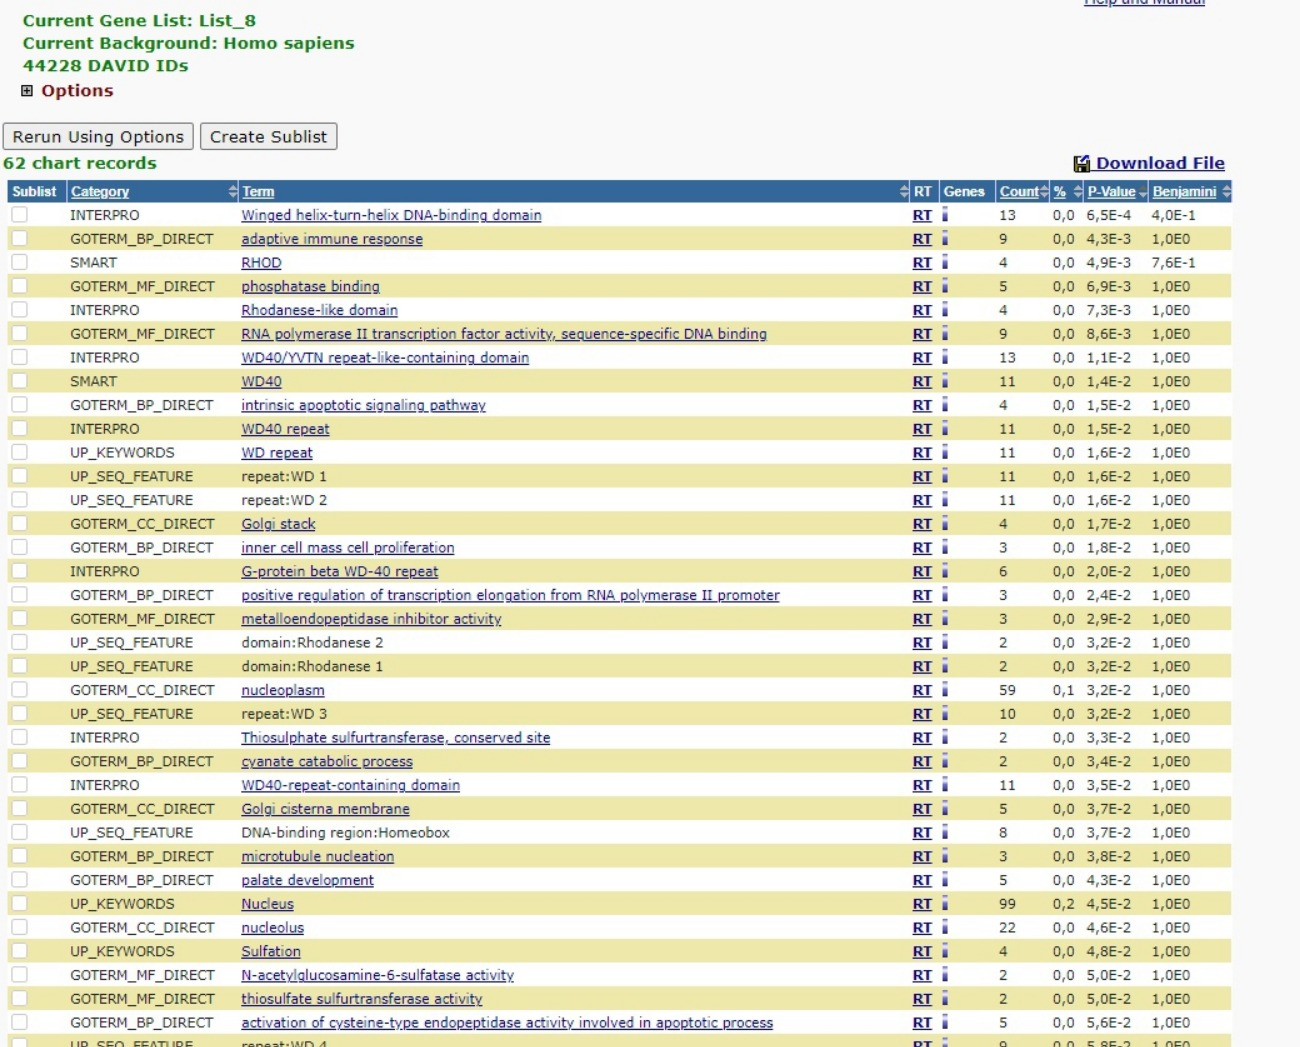

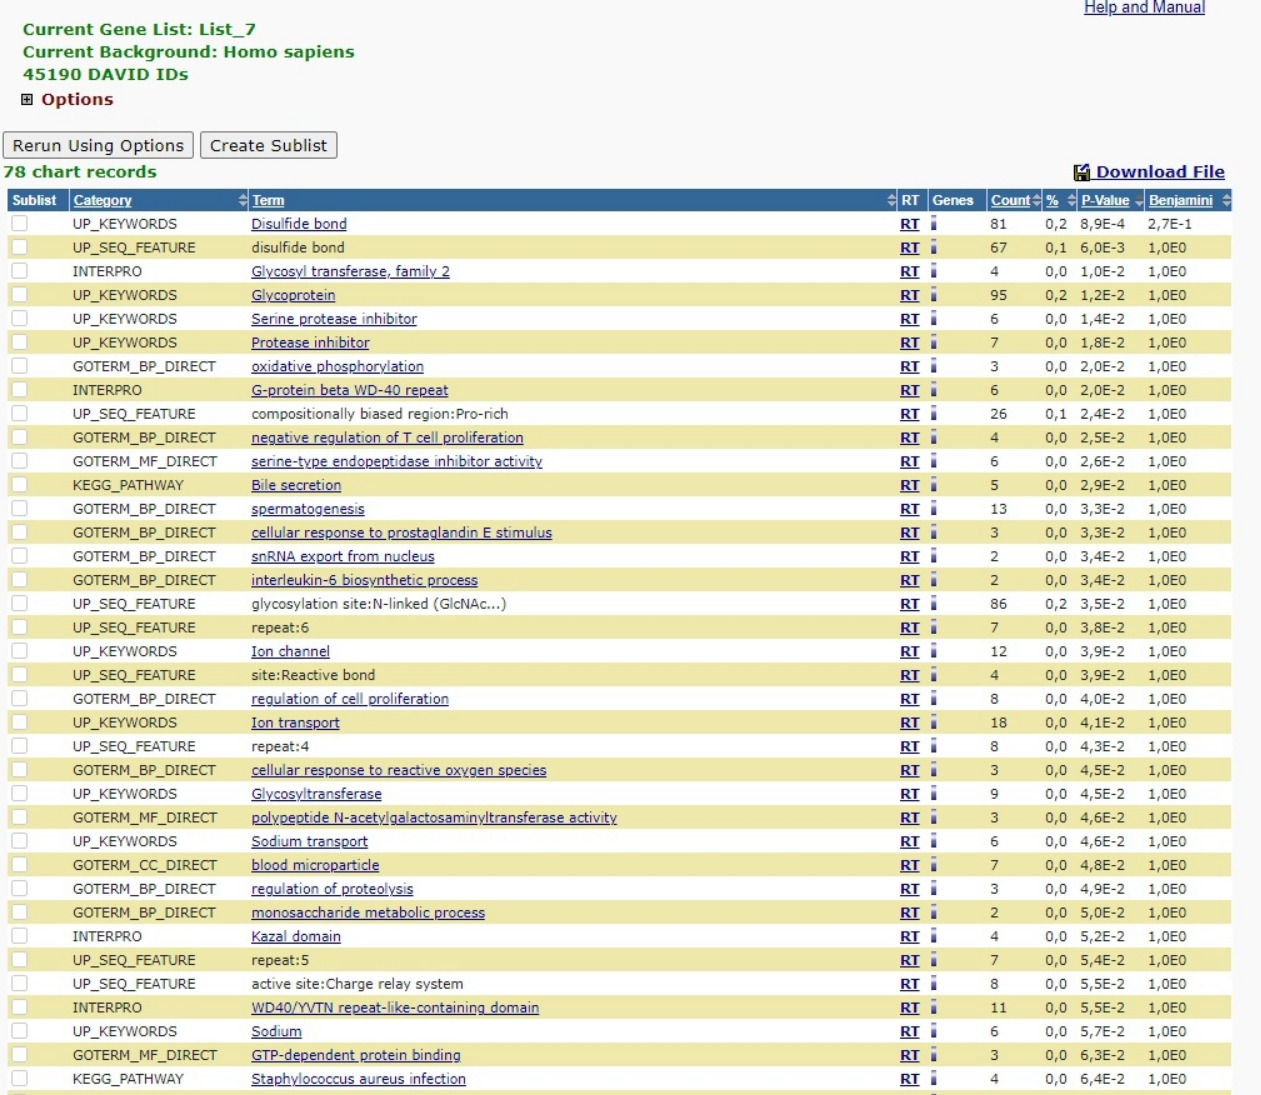